# Tutorial 3: Regressors from ecg data

This example shows how to use *niphlem* for one subject from one of our particular projects. These data consist of one acquisition of resting-state that has been previously preprocesses using *fMRIPrep* and physiological acquired through a Siemens multiband protocol. For the sake of simplicity in this example, we are going to concentrate only on cardiac signal reprsented by the ECG. 

In addition, we are going to show the maps generated by the *niphlem* generated regressors using the library *nilearn* (https://nilearn.github.io/)

In [2]:
# IMPORTS
import numpy as np
import pandas as pd

from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel

from niphlem.input_data import (load_cmrr_info, load_cmrr_data)

Let's start definining our data

In [3]:
# Our preprocessed BOLD image
run_img = image.load_img("./data/demo/sub-06_ses-04_task-resting_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
# The repetition time of the scanner
t_r = 1.5
# The frame times, used to define the regressors at the precise times
n_vols = run_img.shape[-1]
frame_times = np.arange(n_vols)*t_r
# Our file with the confounder regressors as a Dataframe. It will be used later to extract the motion parameters
conf_df = pd.read_csv("./data/demo/sub-06_ses-04_task-resting_run-01_desc-confounds_regressors.tsv", sep="\t")

# Our physiological data, the info log file and the ECG log file
info_log = "./data/demo/physio/Physio_20210322_140315_89a222d1-4c24-4caf-a898-f06c6bfd2342_Info.log"
ecg_log = "./data/demo/physio/Physio_20210322_140315_89a222d1-4c24-4caf-a898-f06c6bfd2342_ECG.log"

### Load data

The first thing that we need is to load the info file, which will give us the times of the scanner. We can load this kind of the data using the function `niphlem.input_data.load_cmrr_info`. The only thing that we have to do is to pass the info log file to this function, and it will return the time traces and a dictionary with some meta information which is at the beginning of the file.

In [4]:
time_traces, meta_info = load_cmrr_info(info_log)

In [5]:
meta_info

{'uuid': '89a222d1-4c24-4caf-a898-f06c6bfd2342',
 'scan_date': '20210322_140315',
 'log_version': 'EJA_1',
 'n_slices': 68,
 'n_vols': 353,
 'n_echoes': 1,
 'init_physio': 20241969,
 'end_physio': 20457989,
 'init_scan': 20246200,
 'end_scan': 20457978,
 'repetition_time': 600.0}

Now that we have the time traces, we are going to load our ECG data by passing to the function `niphlem.input_data.load_cmrr_data` its log file and the meta information dictionary that we've just generated. This dictionary is required to be able to synchronize the physiological signal with the scanner times. We also specify the type of signal, as a new entry to an updated dictionary will be added, containing meta information of this ECG signal.

In [6]:
ecg_signal, meta_info = load_cmrr_data(ecg_log, info_dict=meta_info, sig_type="cardiac")

Let's have a look into a portion of this signal, corresponding to 2 s

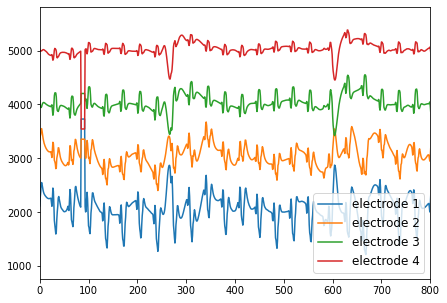

In [7]:
fig, ax =plt.subplots(figsize=(7,5))
plt.plot(ecg_signal[:,0], label="electrode 1")
plt.plot(1000 + ecg_signal[:,1], label="electrode 2")
plt.plot(2000 + ecg_signal[:,2], label="electrode 3")
plt.plot(3000 + ecg_signal[:,3], label="electrode 4")
plt.legend(prop={'size':12})
plt.xlim([0,800])
pass

Let's also have a look at the updated information dictionary.

In [8]:
meta_info

{'uuid': '89a222d1-4c24-4caf-a898-f06c6bfd2342',
 'scan_date': '20210322_140315',
 'log_version': 'EJA_1',
 'n_slices': 68,
 'n_vols': 353,
 'n_echoes': 1,
 'init_physio': 20241969,
 'end_physio': 20457989,
 'init_scan': 20246200,
 'end_scan': 20457978,
 'repetition_time': 600.0,
 'cardiac': {'n_channels': 4, 'sample_rate': 1}}

### Retroicor regressors

Let's start the generation of regressors for the Retroicor Model. The class for generating these regressors is found as `niphlem.models.RetroicorPhysio`.

In [9]:
from niphlem.models import RetroicorPhysio

Let's have a look at the documentation of the class

In [10]:
print(RetroicorPhysio.__doc__)


     Physiological regressors using Retroicor.

    Parameters
    ----------
    physio_rate : float
        Sampling rate for the recording in Hz.
        This is needed for filtering to define the nyquist frequency.
    t_r : float
        Repetition time for the scanner (the usual T_R) in secs.
    delta: float
        minimum separation (in physio recording units) between
        events in signal to be considered peaks
    peak_rise: float
        relative height with respect to the 20th tallest events in signal
        to consider events as peak.
    order: int or array-like of shape (n_orders,)
        Fourier expansion for phases. If int, the fourier expansion is
        performed to that order, starting from 1. If an array is provided,
        each element will multiply the phases.
    transform : {"demean", "zscore", "abs"}, optional
        Transform data before filtering. The default is "demean".
    high_pass : float, optional
        High-pass filtering frequency (in Hz)

We have three required arguments (physio_rate, t_r, delta) and a bunch of optional ones. In our case *physio_rate* is 400 Hz, t_r is 1.5 s and delta=200, the minimu separation between peaks and that corresponds to 200, i.e. 2 peaks per second or at most 120 peaks per minute. 

Before the computing any regressors, we are going to take the mean signal across all the for electrodes and then filter the signal between 0.5 and 3.0 Hz.

Finally, retroicor regressors of order 2 will be generated.

In [11]:
retro_ecg = RetroicorPhysio(physio_rate=400, # Physiological rate (400 Hz)
                            t_r=1.5, # Scan rate (1.5 s)
                            delta=200, 
                            peak_rise=0.5,
                            columns="mean", # mean across the four electrodes
                            low_pass=2.0, # keep frequencies below this
                            high_pass=0.5, # keep frequencies above this
                            order=2 # order 2 of the retroicor expansion
                           )

Once we have defined this object, we generate the regressors using the method `compute_regressors`, which is comon to all the models

In [12]:
retroicor_regressors = retro_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

Let's see the a part of these regressors

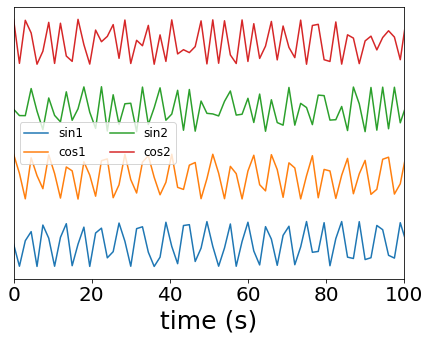

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(frame_times, retroicor_regressors[:,0], label="sin1")
plt.plot(frame_times, 3 + retroicor_regressors[:,1], label="cos1")
plt.plot(frame_times, 6 + retroicor_regressors[:,2], label="sin2")
plt.plot(frame_times, 9 + retroicor_regressors[:,3], label="cos2")
plt.xlim([0,100])
plt.xlabel("time (s)", size=25)
plt.legend(ncol=2, prop={'size':12})
plt.tick_params(labelsize=20)
plt.yticks([])
pass

Let's build now a design matrix that contains these regressors in addition to the motion parameters and an intercept.

In [14]:
dm_retroicor = np.column_stack((np.ones(len(frame_times)), # Intercept
                                conf_df.filter(regex="rot|trans").to_numpy(), # Motion parameters
                                retroicor_regressors # ECG regressors
                               ))
dm_retroicor = pd.DataFrame(dm_retroicor, 
                            columns=["intercept", 
                                     "trans_x","trans_y","trans_z","rot_x","rot_y","rot_z",
                                     "sin1", "cos1", "sin2", "cos2"
                                      ]
                     )
dm_retroicor.index=frame_times
dm_retroicor.head()

,intercept,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,sin1,cos1,sin2,cos2
0.0,1.0,0.031165,-0.003878,-0.027213,-0.001164,0.000187,0.000000,0.000000,1.000000,0.000000,1.000000
1.5,1.0,0.021195,-0.071983,-0.047930,0.000039,0.000260,0.000000,-0.989701,0.143149,-0.283349,-0.959017
3.0,1.0,0.017855,-0.041552,-0.036992,0.000027,0.000076,-0.000260,0.145010,-0.989430,-0.286955,0.957944
4.5,1.0,0.013670,0.072409,-0.036982,-0.000340,0.000188,-0.000202,0.550055,0.835128,0.918733,0.394879
6.0,1.0,0.009882,-0.046013,-0.040077,0.000352,0.000367,-0.000228,-0.999079,0.042905,-0.085731,-0.996318


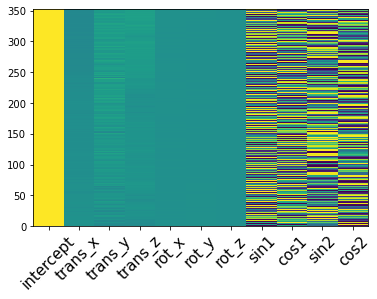

In [15]:
fig, ax = plt.subplots()
ax.pcolormesh(dm_retroicor)
ax.set_xticks(0.5 + np.arange(dm_retroicor.shape[1]))
ax.set_xticklabels(dm_retroicor.columns, rotation=45, size=15)
pass

Now fit this design matrix to our BOLD image

In [16]:
first_level = FirstLevelModel(t_r=t_r, drift_model=None, signal_scaling=False, smoothing_fwhm=6)
first_level.fit(run_imgs=run_img, design_matrices=dm_retroicor)
retroicor_map = first_level.compute_contrast("sin1+cos1+sin2+cos2", stat_type="F", output_type="z_score")

And plot this map in a glass brain fashion

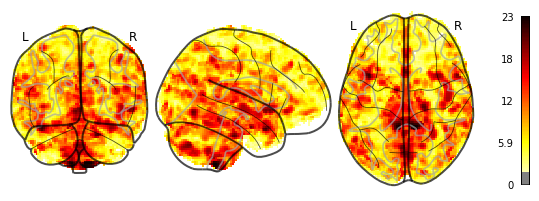

In [17]:
plotting.plot_glass_brain(retroicor_map, colorbar=True, threshold=1.96)

### Variation model's regressors

Let's continue now with the generation of regressors using the Variation Model. The class for generating these regressors is found as `niphlem.models.HVPhysio`.

In [18]:
from niphlem.models import HVPhysio

Let's have a look at the documentation of the class

In [19]:
print(HVPhysio.__doc__)


     Physiological regressors for variations in heart rate.

    Parameters
    ----------
    physio_rate : float
        Sampling rate for the recording in Hz.
        This is needed for filtering to define the nyquist frequency.
    t_r : float
        Repetition time for the scanner (the usual T_R) in secs.
    delta: float
        minimum separation (in physio recording units) between
        events in signal to be considered peaks
    peak_rise: float
        relative height with respect to the 20th tallest events in signal
        to consider events as peak.
    time_window : float
        Time window (in secs) around the T_R from which computing variations
        (time differences between signal events ). The default is 6 secs.
    transform : {"demean", "zscore", "abs"}, optional
        Transform data before filtering. The default is "demean".
    high_pass : float, optional
        High-pass filtering frequency (in Hz). The default is None.
    low_pass : float, optional
 

In [20]:
variaton_ecg = HVPhysio(physio_rate=400, t_r=t_r, delta=200, columns="mean", time_window=4.5,
                        low_pass=2.0, high_pass=0.5, peak_rise=0.5
                       )

In [21]:
variation_regressors = variaton_ecg.compute_regressors(signal=ecg_signal, time_scan=frame_times)

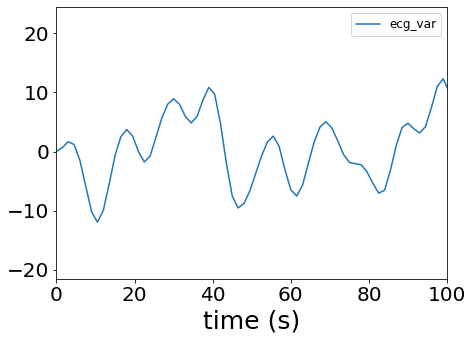

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(frame_times, variation_regressors[:,0], label="ecg_var")
plt.legend()
plt.xlim([0,100])
plt.xlabel("time (s)", size=25)
plt.legend(prop={'size':12})
plt.tick_params(labelsize=20)
pass

In [23]:
dm_variation = np.column_stack((np.ones(len(frame_times)), # Intercept
                                conf_df.filter(regex="rot|trans").to_numpy(), # Motion parameters
                                variation_regressors # ECG regressors
                         ))

dm_variation = pd.DataFrame(dm_variation, 
                            columns=["intercept", 
                                     "trans_x","trans_y","trans_z","rot_x","rot_y","rot_z",
                                     "ecg_var"
                                    ]
                     )
dm_variation.index=frame_times
dm_variation.head()

,intercept,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,ecg_var
0.0,1.0,0.031165,-0.003878,-0.027213,-0.001164,0.000187,0.000000,-0.000677
1.5,1.0,0.021195,-0.071983,-0.047930,0.000039,0.000260,0.000000,0.661642
3.0,1.0,0.017855,-0.041552,-0.036992,0.000027,0.000076,-0.000260,1.652585
4.5,1.0,0.013670,0.072409,-0.036982,-0.000340,0.000188,-0.000202,1.194417
6.0,1.0,0.009882,-0.046013,-0.040077,0.000352,0.000367,-0.000228,-1.499796


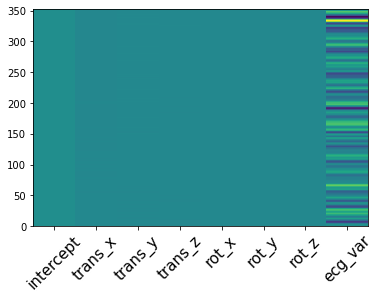

In [24]:
fig, ax = plt.subplots()
ax.pcolormesh(dm_variation)
ax.set_xticks(0.5 + np.arange(dm_variation.shape[1]))
ax.set_xticklabels(dm_variation.columns, rotation=45, size=15)
pass

Again, let's fit this design matrix to our BOLD data and show the pattern obtained

In [25]:
first_level = FirstLevelModel(t_r=t_r, drift_model=None, signal_scaling=False, smoothing_fwhm=6)
first_level.fit(run_imgs=run_img, design_matrices=dm_variation)
variation_map = first_level.compute_contrast("ecg_var", stat_type="F", output_type="z_score")

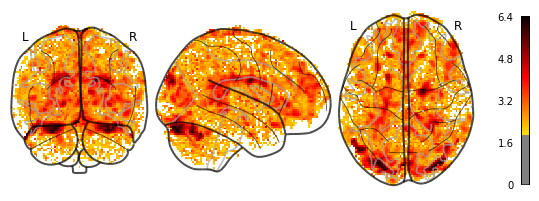

In [26]:
plotting.plot_glass_brain(variation_map, colorbar=True, threshold=1.96)